### Get Transition Probabilities

In [118]:
from collections import defaultdict
from itertools import product, combinations, chain
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math

In [119]:
def getPossibleStates(edges, max_age):
    """
    Returns: list of states, where each state is a tuple of ((edge), age)
    """
    sorted_edges = sorted(tuple(sorted(e)) for e in edges)
    possible_ages = [-1] + list(range(1, max_age + 1))

    all_states = [
        tuple(zip(sorted_edges, age_combo))
        for age_combo in product(possible_ages, repeat=len(sorted_edges))
    ]

    return all_states

def getAgedStates(state, maxAge):
    """
    Returns:
        New state as a tuple of ((edge), age) pairs
    """
    new_state = []
    for edge, age in state:
        if age == -1:
            new_state.append((edge, -1))  # not entangled
        else:
            new_age = age + 1
            if new_age <= maxAge:
                new_state.append((edge, new_age))
            else:
                new_state.append((edge, -1))  # entanglement expired

    return tuple(sorted(new_state))


def generateAllOutcomes(state, pGen):
    empty_edges = [edge for edge, age in state if age == -1]
    outcomes = []

    for pattern in product([0, 1], repeat=len(empty_edges)):
        prob = 1.0
        new_state = []

        # First, update the empty edges based on entanglement outcomes
        outcome_map = {}
        for (edge, outcome) in zip(empty_edges, pattern):
            if outcome:
                prob *= pGen
                outcome_map[edge] = 1
            else:
                prob *= (1 - pGen)
                outcome_map[edge] = -1

        # Now build the full new state
        for edge, age in state:
            if edge in outcome_map:
                new_state.append((edge, outcome_map[edge]))
            else:
                new_state.append((edge, age))  # unchanged

        outcomes.append((tuple(sorted(new_state)), prob))

    return outcomes

def generateAllSwappingOutcomes(state, goalEdges, pSwap):
    """
    Generate all possible outcomes from swapping operations or doing nothing.
    Can attempt multiple non-overlapping swaps simultaneously.
    """
    def find_path(current, target, visited):
        if current == target:
            return [current]
        visited.add(current)
        for next_node in graph.get(current, []):
            if next_node not in visited:
                path = find_path(next_node, target, visited)
                if path:
                    return [current] + path
        return None

    # First find all possible individual swap attempts
    swap_attempts = []
    entangled_edges = [(edge, age) for edge, age in state if age > 0]
    
    # Create graph once for all path finding
    graph = {}
    for (edge, _) in entangled_edges:
        if edge[0] not in graph: graph[edge[0]] = []
        if edge[1] not in graph: graph[edge[1]] = []
        graph[edge[0]].append(edge[1])
        graph[edge[1]].append(edge[0])
    
    # Find all possible paths for each goal
    for goal_edge in goalEdges:
        start, end = goal_edge
        path = find_path(start, end, set())
        
        if path and len(path) > 1:
            path_edges = list(zip(path[:-1], path[1:]))
            used_edges = []
            for p_edge in path_edges:
                for e, age in entangled_edges:
                    if (e[0] == p_edge[0] and e[1] == p_edge[1]) or \
                       (e[0] == p_edge[1] and e[1] == p_edge[0]):
                        used_edges.append((e, age))
            
            swap_attempts.append({
                'goal': goal_edge,
                'used_edges': used_edges,
                'num_swaps': len(path_edges) - 1
            })
    
    outcomes = []
    
    # Case 1: Do nothing
    outcomes.append((state, 1.0, None))
    
    # Case 2: Try all possible combinations of non-overlapping swaps
    for r in range(1, len(swap_attempts) + 1):
        for attempt_combo in combinations(swap_attempts, r):
            # Check if attempts are compatible (don't share edges)
            all_used_edges = set()
            edge_overlap = False
            for attempt in attempt_combo:
                attempt_edges = set(e for e, _ in attempt['used_edges'])
                if any(e in all_used_edges for e in attempt_edges):
                    edge_overlap = True
                    break
                all_used_edges.update(attempt_edges)
            
            if edge_overlap:
                continue
                
            # Generate all success/failure combinations for this set of attempts
            for success_pattern in product([True, False], repeat=len(attempt_combo)):
                new_state = []
                total_prob = 1.0
                achieved_goals = []
                
                # Calculate probability and track achieved goals
                for attempt, succeeded in zip(attempt_combo, success_pattern):
                    prob = pSwap ** attempt['num_swaps'] if succeeded else \
                          (1 - pSwap ** attempt['num_swaps'])
                    total_prob *= prob
                    if succeeded:
                        achieved_goals.append((attempt['goal'], True))
                    else:
                        achieved_goals.append((attempt['goal'], False))
                
                # Create new state
                for edge, age in state:
                    if any(edge == e for attempt in attempt_combo 
                          for e, _ in attempt['used_edges']):
                        new_state.append((edge, -1))  # Used edges become unentangled
                    else:
                        new_state.append((edge, age))  # Other edges remain unchanged
                
                new_state = tuple(sorted(new_state))
                outcomes.append((new_state, total_prob, achieved_goals))
    
    return outcomes


In [120]:
def getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        List of (new_state, probability, achieved_goals) tuples
    """
    all_transitions = []
    
    # Get all possible swap action outcomes
    swap_outcomes = generateAllSwappingOutcomes(state, goalEdges, pSwap)
    
    # For each swap outcome, generate all possible generation outcomes
    for swap_state, swap_prob, achieved_goals in swap_outcomes:
        # Skip if swap probability is 0
        if swap_prob == 0:
            continue
            
        # First age the state
        aged_state = getAgedStates(swap_state, maxAge)
        
        # Then get all possible generation outcomes
        gen_outcomes = generateAllOutcomes(aged_state, pGen)
        
        # Combine the probabilities and add to transitions
        for final_state, gen_prob in gen_outcomes:
            # Skip if either probability is 0
            if gen_prob == 0:
                continue
                
            all_transitions.append((
                final_state,
                swap_prob * gen_prob,
                achieved_goals
            ))
    
    return all_transitions

def generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        Dictionary mapping state -> list of (next_state, prob, achieved_goals)
    """
    # Get all possible states
    all_states = getPossibleStates(edges, maxAge)
    transitions = {}
    
    # For each state, calculate all possible transitions
    for state in all_states:
        transitions[state] = getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge)
    
    return transitions

### Value Iteration


In [121]:
# Update the edges definition
edges = [(0, 1), (1, 2), (2, 3)]
edges = sorted(edges, key=lambda x: (x[0], x[1]))  # Just sort the edges first
initial_state = tuple((edge, -1) for edge in edges)  # Then create the state format

goalEdges = [(0, 3)]
pSwap = 0.5
pGen = 0.2
maxAge = 2

# Generate transitions with the new network topology
all_transitions = generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge)   
print("Number of states:", len(all_transitions))

Number of states: 27


Initial state: (((0, 1), -1), ((1, 2), -1), ((2, 3), -1))
Number of states in values dict: 27
Is initial state in values dict? True
Converged after 55 iterations


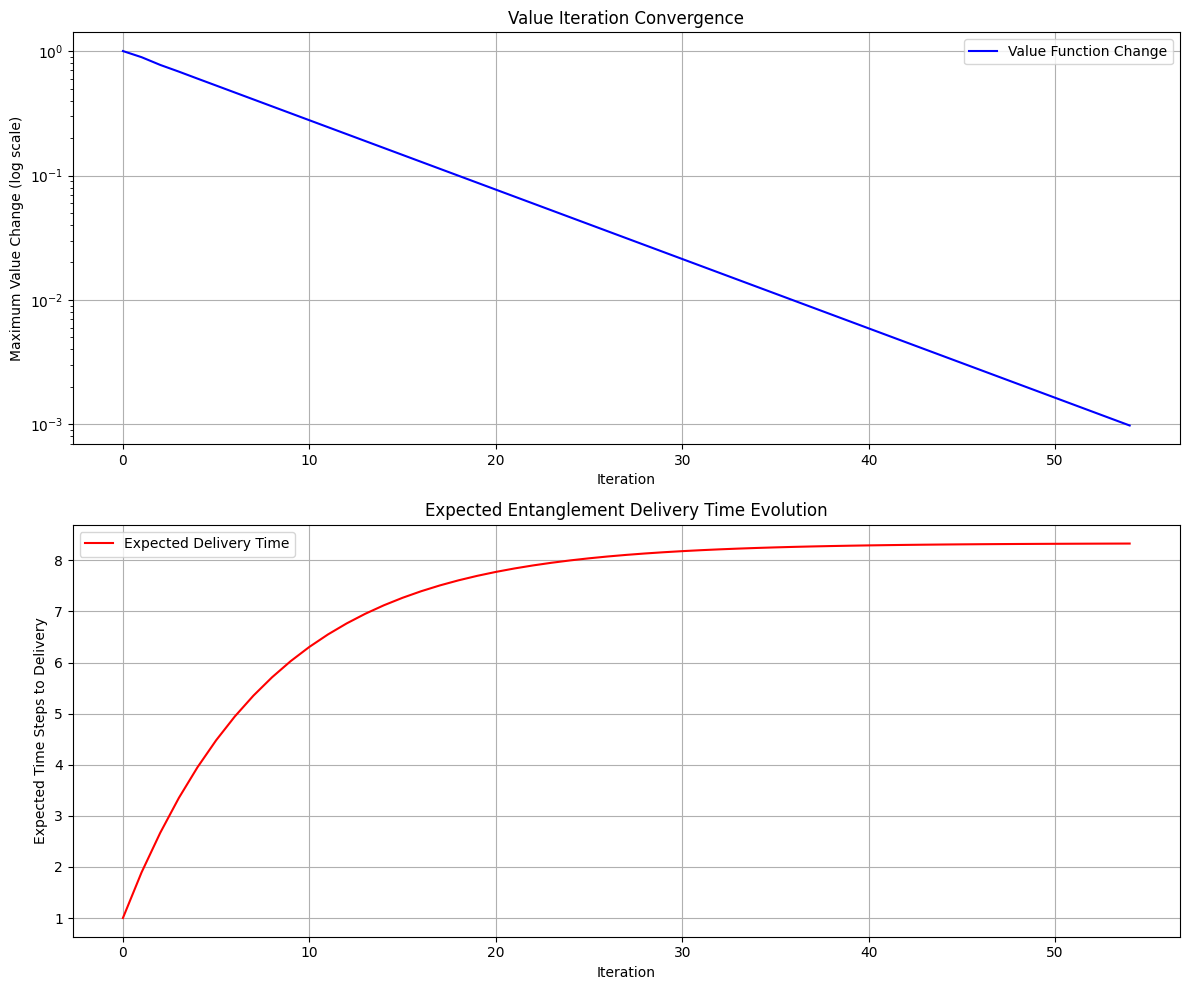


=== Final Statistics ===
Final expected delivery time: 8.33 time steps
Parameters: pSwap=0.5, pGen=0.2, maxAge=2
Network: edges=[(0, 1), (1, 2), (2, 3)], goals=[(0, 3)]


In [122]:
def getImmediateReward(achieved_goals):
    # Check if any end-to-end entanglement was achieved
    if achieved_goals is not None and any(success for _, success in achieved_goals):
        return 0  # Goal reached
    return -1  # Time step penalty until goal is reached


def has_improved_state(state, next_state):
    """
    Check if the action resulted in longer-distance entanglement
    or freed up memory for new entanglement generation
    """
    # Implementation depends on your state representation
    pass


initial_state = tuple((edge, -1) for edge in edges)
values = {state: 0 for state in all_transitions.keys()}
policy = {state: None for state in all_transitions.keys()}
convergence_data = []

# Debug print to verify state format
print("Initial state:", initial_state)
print("Number of states in values dict:", len(values))
print("Is initial state in values dict?", initial_state in values)


# Global tracking variables
total_timesteps = 1
goal_success_counts = {goal: 0 for goal in goalEdges}
edr_history = {goal: [] for goal in goalEdges}

# Value iteration parameters
gamma = 0.9
epsilon = 0.001
max_iterations = 1000

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Run value iteration
delivery_times = []  # Track expected delivery time per iteration
for iteration in range(max_iterations):
    delta = 0
    new_values = values.copy()
    
    # Update value for each state
    for state in all_transitions.keys():
        action_values = defaultdict(float)
        
        for next_state, prob, achieved_goals in all_transitions[state]:
            immediate_reward = getImmediateReward(achieved_goals)
            future_value = gamma * values[next_state]
            action_values[str(achieved_goals)] += prob * (immediate_reward + future_value)
        
        if action_values:
            best_action = max(action_values.items(), key=lambda x: x[1])
            new_values[state] = best_action[1]
            policy[state] = eval(best_action[0]) if best_action[0] != 'None' else None
            delta = max(delta, abs(new_values[state] - values[state]))
    
    # Update values
    values = new_values
    convergence_data.append(delta)
    
    # Calculate expected delivery time for initial state
    # The negative of the value function gives us the expected steps to goal
    delivery_times.append(-values[initial_state])
    
    # Check for convergence
    if delta < epsilon:
        print(f"Converged after {iteration + 1} iterations")
        break

# Plot convergence
ax1.plot(convergence_data, 'b-', label='Value Function Change')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Maximum Value Change (log scale)')
ax1.set_title('Value Iteration Convergence')
ax1.grid(True)
ax1.legend()

# Plot expected delivery time
ax2.plot(delivery_times, 'r-', label='Expected Delivery Time')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Expected Time Steps to Delivery')
ax2.set_title('Expected Entanglement Delivery Time Evolution')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Print final statistics
print("\n=== Final Statistics ===")
print(f"Final expected delivery time: {delivery_times[-1]:.2f} time steps")
print(f"Parameters: pSwap={pSwap}, pGen={pGen}, maxAge={maxAge}")
print(f"Network: edges={edges}, goals={goalEdges}")

### **Evaluate with EDR**


=== Policy Evaluation Results ===
Average delivery time: 29.33 steps
Success rate: 95.10%
Parameters: pSwap=0.5, pGen=0.2, maxAge=2
Network: edges=[(0, 1), (1, 2), (2, 3)], goals=[(0, 3)]


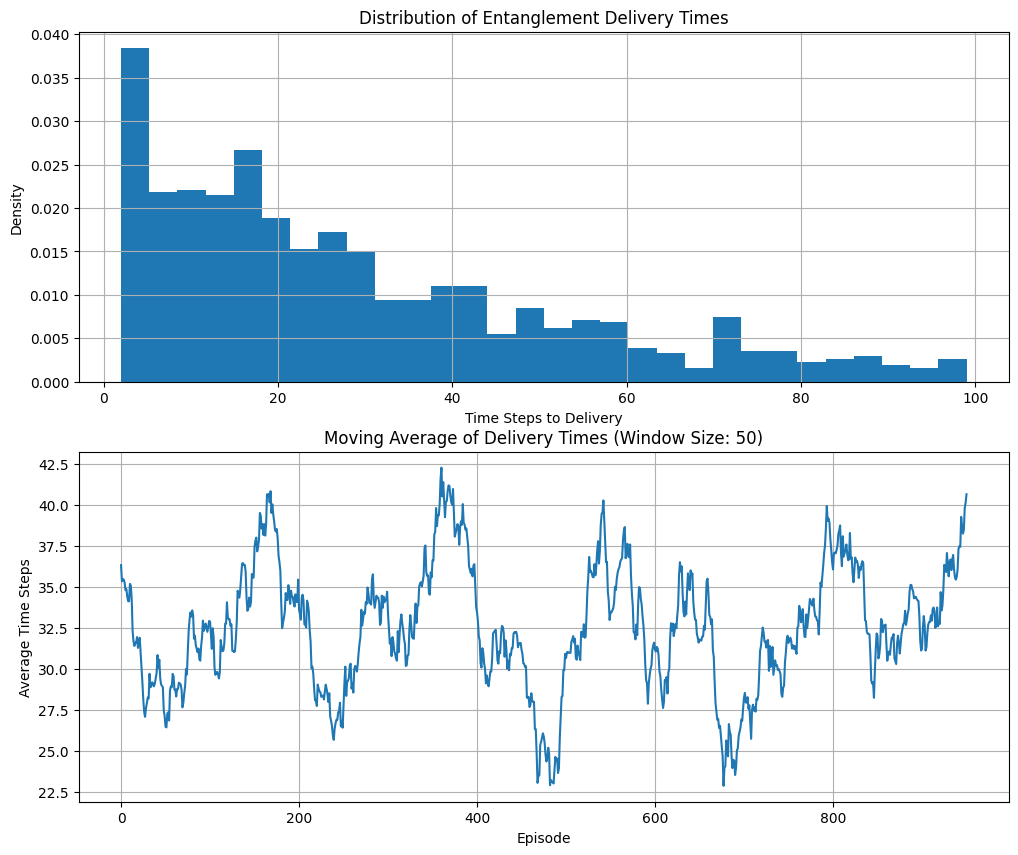

In [123]:
# Create correct initial state format
initial_state = tuple((edge, -1) for edge in edges)

# Statistics tracking
delivery_times = []  # Track time to achieve e2e entanglement
episode_steps = []   # Track steps per episode
success_rate = []    # Track success rate

# Run multiple episodes
n_episodes = 1000
max_steps = 100

for episode in range(n_episodes):
    current_state = initial_state
    steps_taken = 0
    success = False
    
    for step in range(max_steps):
        possible_transitions = all_transitions[current_state]
        policy_action = policy[current_state]
        valid_transitions = [
            (next_state, prob, achieved) 
            for next_state, prob, achieved in possible_transitions
            if achieved == policy_action
        ]
        
        if not valid_transitions:
            break
            
        # Choose transition based on probabilities
        probs = [prob for _, prob, _ in valid_transitions]
        probs = np.array(probs) / sum(probs)  # Normalize probabilities
        chosen_idx = np.random.choice(len(valid_transitions), p=probs)
        next_state, _, achieved_goals = valid_transitions[chosen_idx]
        
        steps_taken += 1
        
        # Check if end-to-end entanglement was achieved
        if achieved_goals is not None and any(success for _, success in achieved_goals):
            success = True
            delivery_times.append(steps_taken)
            break
            
        current_state = next_state
    
    episode_steps.append(steps_taken)
    success_rate.append(1 if success else 0)

# Create three subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot delivery times
successful_deliveries = np.array(delivery_times)
ax1.hist(successful_deliveries, bins=30, density=True)
ax1.set_title('Distribution of Entanglement Delivery Times')
ax1.set_xlabel('Time Steps to Delivery')
ax1.set_ylabel('Density')
ax1.grid(True)

# Plot moving average of delivery times
window_size = 50  # Adjust for smoother/rougher averaging
moving_avg = np.convolve(episode_steps, np.ones(window_size)/window_size, mode='valid')
ax2.plot(range(len(moving_avg)), moving_avg)
ax2.set_title(f'Moving Average of Delivery Times (Window Size: {window_size})')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Average Time Steps')
ax2.grid(True)

# Print final statistics
print("\n=== Policy Evaluation Results ===")
print(f"Average delivery time: {np.mean(delivery_times):.2f} steps")
print(f"Success rate: {np.mean(success_rate):.2%}")
print(f"Parameters: pSwap={pSwap}, pGen={pGen}, maxAge={maxAge}")
print(f"Network: edges={edges}, goals={goalEdges}")